# Bangla Cyberbullying Classification with BiLSTM

This notebook implements a BiLSTM classifier for multi-class classification of Bangla cyberbullying text.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.preprocessing import label_binarize
from sklearn.discriminant_analysis import StandardScaler
from bnlp import SentencepieceTokenizer
from bnlp.embedding.fasttext import BengaliFasttext
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from transformers import AutoTokenizer, AutoModel
from itertools import cycle
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Set plot style
plt.style.use("ggplot")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

In [3]:
MY_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(MY_DEVICE)

'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "caching_allocator"

## 1. Loading and Exploring Datasets

In [5]:
# 1. Load the datasets
print("Loading datasets...")
original_cleaned_df = pd.read_csv("../../dataset/cleaned/original_cleaned.csv")
only_augmented_cleaned_df = pd.read_csv("../../dataset/cleaned/only_augmented.csv")

print(f"Original dataset shape: {original_cleaned_df.shape}")
print(f"Augmented dataset shape: {only_augmented_cleaned_df.shape}")

Loading datasets...
Original dataset shape: (41907, 6)
Augmented dataset shape: (6081, 3)


In [6]:
# Display the first few rows of original dataset
original_cleaned_df.head()

,comment,Category,Gender,comment react number,label,text_length
0,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...,Actor,Female,1.0,sexual,128
1,ঘরে শুট কেমন লেগেছে ক্যামেরাতে,Singer,Male,2.0,not bully,30
2,অরে বাবা টা পাগল,Actor,Female,2.0,not bully,16
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully,21
4,পটকা মাছ,Politician,Male,0.0,troll,8


## 2. Label Mapping and Visualization

In [7]:
# Map the labels for both datasets
label_mapping = {"not bully": 0, "troll": 1, "sexual": 2, "religious": 3, "threat": 4}

original_cleaned_df["label_encoded"] = original_cleaned_df["label"].map(label_mapping)
only_augmented_cleaned_df["label_encoded"] = only_augmented_cleaned_df["label"].map(
    label_mapping
)

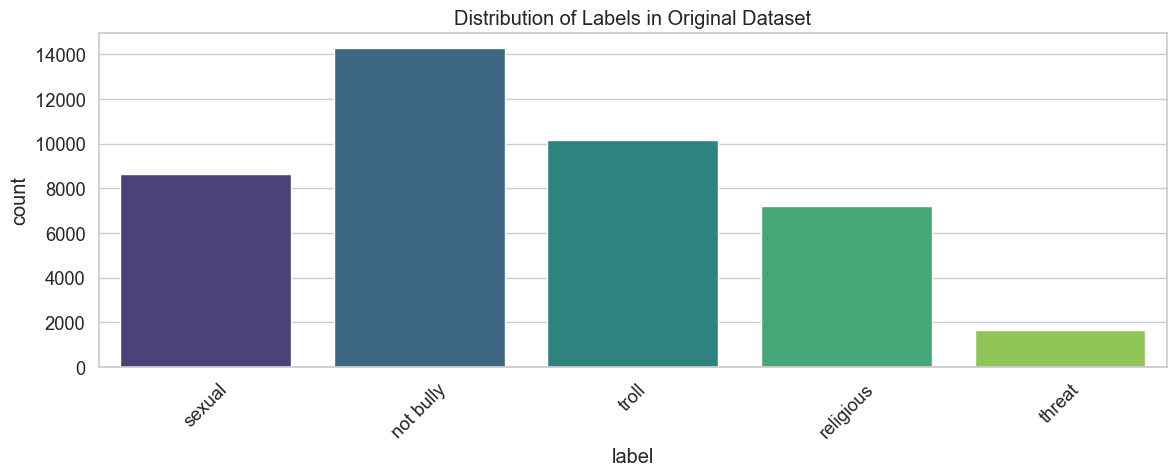

In [8]:
# Check the distribution of labels
plt.figure(figsize=(12, 5))
sns.countplot(x="label", data=original_cleaned_df, palette="viridis")
plt.title("Distribution of Labels in Original Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Data Splitting and Augmentation

In [9]:
# Split the original dataset into train and test sets
X = original_cleaned_df["comment"]
y = original_cleaned_df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size before augmentation: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size before augmentation: 33525
Test set size: 8382


In [10]:
# Add augmented data to the training set
X_aug = only_augmented_cleaned_df["text"]
y_aug = only_augmented_cleaned_df["label_encoded"]

# Concatenate original training data with augmented data
X_train_augmented = pd.concat([X_train, X_aug])
y_train_augmented = pd.concat([y_train, y_aug])

print(f"Training set size after augmentation: {len(X_train_augmented)}")

Training set size after augmentation: 39606


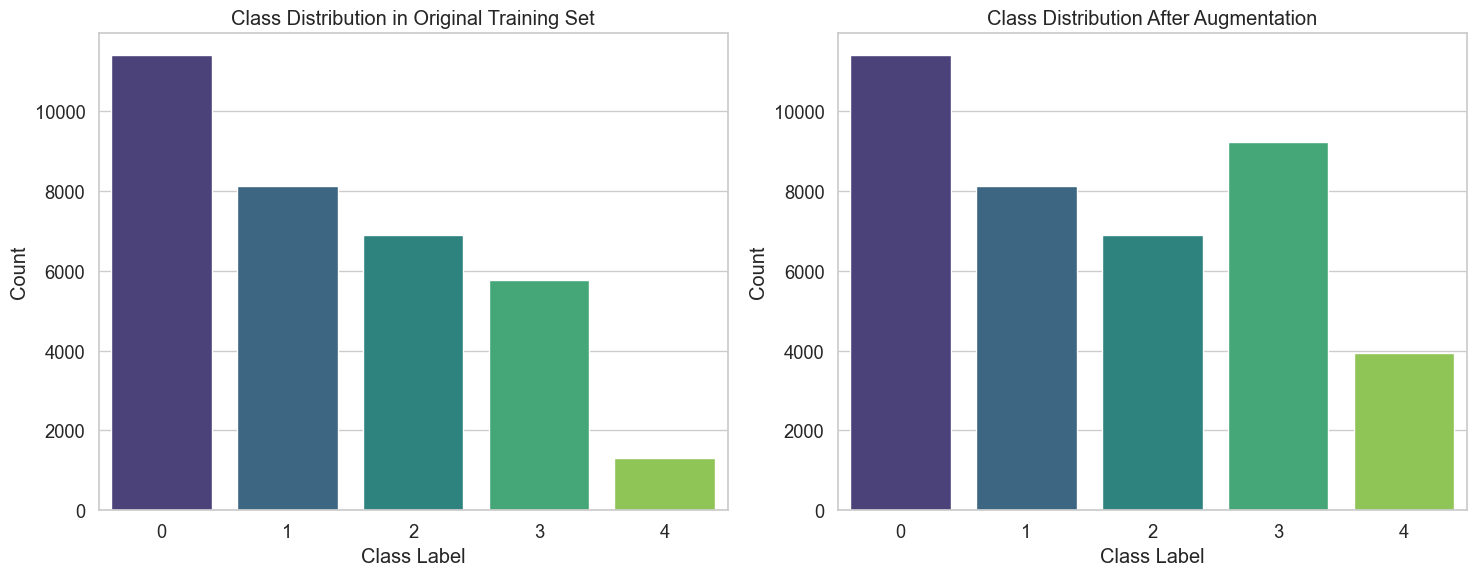

In [11]:
# Visualize the class distribution before and after augmentation
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette="viridis")
plt.title("Class Distribution in Original Training Set")
plt.xlabel("Class Label")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_augmented, palette="viridis")
plt.title("Class Distribution After Augmentation")
plt.xlabel("Class Label")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## 4. Text Tokenization and Vectorization Via BanglaBERT

In [12]:
bangla_bert_tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
bangla_bert_model = AutoModel.from_pretrained("sagorsarker/bangla-bert-base")

In [13]:
def fit_and_return_hidden_layer(input_text_array: np.ndarray):
    """
    Fit the input array to the Bengali BERT model and return the concatenated last 4 hidden layers.
    """
    torch.cuda.empty_cache()
    tokenized_input = bangla_bert_tokenizer(
        input_text_array.tolist(),
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=100,
    )

    # Move the tokenized input to GPU
    tokenized_input = {k: v.to(MY_DEVICE) for k, v in tokenized_input.items()}

    # Put model in eval mode and move to GPU if not already there
    bangla_bert_model.eval()
    bangla_bert_model.to(MY_DEVICE)

    # Process in batches to avoid memory issues
    batch_size = 32
    num_samples = tokenized_input["input_ids"].shape[0]
    all_hidden_layers = []

    with torch.no_grad():  # Don't compute gradients for inference
        for i in range(0, num_samples, batch_size):
            batch_input = {k: v[i : i + batch_size] for k, v in tokenized_input.items()}

            with torch.amp.autocast(device_type="cuda"):
                outputs = bangla_bert_model(**batch_input, output_hidden_states=True)
                hidden_states = (
                    outputs.hidden_states
                )  # Tuple containing all hidden layers

                # Get the last 4 hidden layers and concatenate them
                last_4_layers = torch.cat(hidden_states[-4:], dim=-1)

                # Average across all tokens (mean pooling)
                hidden_layer = last_4_layers.mean(dim=1)

            # Move to CPU and detach from computation graph
            hidden_layer_cpu = hidden_layer.detach().cpu()
            reshaped_hidden_layer = hidden_layer_cpu.reshape(
                hidden_layer_cpu.shape[0], -1
            )
            all_hidden_layers.append(reshaped_hidden_layer)

    # Concatenate all batches
    combined_hidden_layers = torch.cat(all_hidden_layers, dim=0)

    return combined_hidden_layers.numpy()

In [14]:
# Apply tokenization and vectorization to training data
print("Vectorizing training data...")
start_time = time.time()
X_train_vectors = fit_and_return_hidden_layer(X_train_augmented.values)
print(
    f"Training data vectorization completed in {time.time() - start_time:.2f} seconds"
)
print(f"Training data shape: {X_train_vectors.shape}")

Vectorizing training data...
Training data vectorization completed in 77.26 seconds
Training data shape: (39606, 3072)


In [15]:
# Apply tokenization and vectorization to testing data
print("Vectorizing testing data...")
start_time = time.time()
X_test_vectors = fit_and_return_hidden_layer(X_test.values)
print(f"Testing data vectorization completed in {time.time() - start_time:.2f} seconds")

Vectorizing testing data...
Testing data vectorization completed in 16.63 seconds


In [16]:
# For runing without PCA
X_train_pca = X_train_vectors
X_test_pca = X_test_vectors

# Dimensionality reduction to visualize the features


# scaler = StandardScaler()

# print("Performing dimensionality reduction...")
# start_time = time.time()

# # First use PCA to reduce to 50 dimensions (makes t-SNE faster)
# print("Applying PCA...")
# pca = PCA(n_components=0.95, random_state=42)  # Keep 95% of variance
# X_train_pca = pca.fit_transform(scaler.fit_transform(X_train_vectors))
# X_test_pca = pca.transform(scaler.transform(X_test_vectors))
# print(f"PCA completed in {time.time() - start_time:.2f} seconds")

# Then apply t-SNE on the PCA results
# print("Applying t-SNE...")
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_jobs=-1)
# X_train_tsne = tsne.fit_transform(X_train_pca)
# print(f"t-SNE completed in {time.time() - start_time:.2f} seconds")

# # Visualize the 2D projection
# plt.figure(figsize=(12, 10))
# scatter = plt.scatter(
#     X_train_tsne[:, 0],
#     X_train_tsne[:, 1],
#     c=y_train_augmented,
#     alpha=0.5,
#     cmap="viridis",
# )
# plt.colorbar(scatter, label="Class")
# plt.title("t-SNE Visualization of BERT Embeddings")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.tight_layout()
# plt.show()

## 5. Implementing BiLSTM Model

In [17]:
# Define the BiLSTM model architecture
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Bidirectional LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layer for classification
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),  # * 2 because of bidirectional
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
        
    def forward(self, x):
        # Reshape input to (batch_size, sequence_length, features)
        batch_size = x.size(0)
        x = x.unsqueeze(1)  # Add sequence dimension (since we're treating each embedding as a single sequence)
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)  # * 2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
        
        # Forward propagate through the LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Get the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        
        # Classify
        out = self.fc(lstm_out)
        return out

Training BiLSTM model...


Epoch [1/100]: 100%|██████████| 557/557 [00:06<00:00, 81.03it/s, acc=0.569, loss=0.98] 


Epoch 1/100, Train Loss: 1.0931, Train Acc: 0.5686, Val Loss: 0.9372, Val Acc: 0.6338


Epoch [2/100]: 100%|██████████| 557/557 [00:06<00:00, 85.05it/s, acc=0.626, loss=0.914]


Epoch 2/100, Train Loss: 0.9666, Train Acc: 0.6260, Val Loss: 0.9440, Val Acc: 0.6364


Epoch [3/100]: 100%|██████████| 557/557 [00:06<00:00, 86.08it/s, acc=0.641, loss=0.823]


Epoch 3/100, Train Loss: 0.9278, Train Acc: 0.6411, Val Loss: 0.8737, Val Acc: 0.6624


Epoch [4/100]: 100%|██████████| 557/557 [00:06<00:00, 85.39it/s, acc=0.657, loss=0.828]


Epoch 4/100, Train Loss: 0.8924, Train Acc: 0.6574, Val Loss: 0.8517, Val Acc: 0.6669


Epoch [5/100]: 100%|██████████| 557/557 [00:06<00:00, 83.43it/s, acc=0.665, loss=1]    


Epoch 5/100, Train Loss: 0.8682, Train Acc: 0.6648, Val Loss: 0.8614, Val Acc: 0.6699


Epoch [6/100]: 100%|██████████| 557/557 [00:06<00:00, 81.08it/s, acc=0.671, loss=0.568]


Epoch 6/100, Train Loss: 0.8514, Train Acc: 0.6711, Val Loss: 0.8349, Val Acc: 0.6790


Epoch [7/100]: 100%|██████████| 557/557 [00:06<00:00, 81.11it/s, acc=0.683, loss=0.718]


Epoch 7/100, Train Loss: 0.8358, Train Acc: 0.6829, Val Loss: 0.8326, Val Acc: 0.6778


Epoch [8/100]: 100%|██████████| 557/557 [00:06<00:00, 79.77it/s, acc=0.683, loss=0.726]


Epoch 8/100, Train Loss: 0.8264, Train Acc: 0.6835, Val Loss: 0.8281, Val Acc: 0.6710


Epoch [9/100]: 100%|██████████| 557/557 [00:07<00:00, 73.54it/s, acc=0.69, loss=0.744] 


Epoch 9/100, Train Loss: 0.8074, Train Acc: 0.6899, Val Loss: 0.8144, Val Acc: 0.6848


Epoch [10/100]: 100%|██████████| 557/557 [00:07<00:00, 77.57it/s, acc=0.696, loss=0.693]


Epoch 10/100, Train Loss: 0.7971, Train Acc: 0.6956, Val Loss: 0.8250, Val Acc: 0.6848


Epoch [11/100]: 100%|██████████| 557/557 [00:07<00:00, 78.53it/s, acc=0.698, loss=0.809]


Epoch 11/100, Train Loss: 0.7903, Train Acc: 0.6979, Val Loss: 0.8473, Val Acc: 0.6755


Epoch [12/100]: 100%|██████████| 557/557 [00:07<00:00, 78.13it/s, acc=0.701, loss=0.581]


Epoch 12/100, Train Loss: 0.7788, Train Acc: 0.7013, Val Loss: 0.8168, Val Acc: 0.6881


Epoch [13/100]: 100%|██████████| 557/557 [00:07<00:00, 78.08it/s, acc=0.709, loss=0.572]


Epoch 13/100, Train Loss: 0.7631, Train Acc: 0.7087, Val Loss: 0.8109, Val Acc: 0.6912


Epoch [14/100]: 100%|██████████| 557/557 [00:07<00:00, 79.45it/s, acc=0.713, loss=0.845]


Epoch 14/100, Train Loss: 0.7524, Train Acc: 0.7132, Val Loss: 0.8187, Val Acc: 0.6937


Epoch [15/100]: 100%|██████████| 557/557 [00:07<00:00, 77.16it/s, acc=0.716, loss=0.992]


Epoch 15/100, Train Loss: 0.7483, Train Acc: 0.7160, Val Loss: 0.8044, Val Acc: 0.6894


Epoch [16/100]: 100%|██████████| 557/557 [00:07<00:00, 74.69it/s, acc=0.721, loss=0.649]


Epoch 16/100, Train Loss: 0.7325, Train Acc: 0.7212, Val Loss: 0.7975, Val Acc: 0.6894


Epoch [17/100]: 100%|██████████| 557/557 [00:07<00:00, 72.60it/s, acc=0.727, loss=0.567]


Epoch 17/100, Train Loss: 0.7222, Train Acc: 0.7266, Val Loss: 0.7959, Val Acc: 0.6891


Epoch [18/100]: 100%|██████████| 557/557 [00:07<00:00, 76.44it/s, acc=0.729, loss=0.795]


Epoch 18/100, Train Loss: 0.7081, Train Acc: 0.7289, Val Loss: 0.8114, Val Acc: 0.6884


Epoch [19/100]: 100%|██████████| 557/557 [00:07<00:00, 77.16it/s, acc=0.731, loss=0.704]


Epoch 19/100, Train Loss: 0.7047, Train Acc: 0.7313, Val Loss: 0.7958, Val Acc: 0.7000


Epoch [20/100]: 100%|██████████| 557/557 [00:07<00:00, 77.97it/s, acc=0.74, loss=0.519] 


Epoch 20/100, Train Loss: 0.6891, Train Acc: 0.7402, Val Loss: 0.8013, Val Acc: 0.7033


Epoch [21/100]: 100%|██████████| 557/557 [00:07<00:00, 79.46it/s, acc=0.74, loss=0.748] 


Epoch 21/100, Train Loss: 0.6802, Train Acc: 0.7401, Val Loss: 0.7960, Val Acc: 0.6952


Epoch [22/100]: 100%|██████████| 557/557 [00:07<00:00, 78.62it/s, acc=0.744, loss=0.799]


Epoch 22/100, Train Loss: 0.6805, Train Acc: 0.7437, Val Loss: 0.7843, Val Acc: 0.7076


Epoch [23/100]: 100%|██████████| 557/557 [00:06<00:00, 79.61it/s, acc=0.747, loss=0.805]


Epoch 23/100, Train Loss: 0.6661, Train Acc: 0.7468, Val Loss: 0.8281, Val Acc: 0.6879


Epoch [24/100]: 100%|██████████| 557/557 [00:07<00:00, 78.16it/s, acc=0.748, loss=0.612]


Epoch 24/100, Train Loss: 0.6681, Train Acc: 0.7482, Val Loss: 0.8129, Val Acc: 0.7003


Epoch [25/100]: 100%|██████████| 557/557 [00:07<00:00, 79.04it/s, acc=0.753, loss=0.629]


Epoch 25/100, Train Loss: 0.6519, Train Acc: 0.7526, Val Loss: 0.7721, Val Acc: 0.7063


Epoch [26/100]: 100%|██████████| 557/557 [00:07<00:00, 78.50it/s, acc=0.757, loss=0.948]


Epoch 26/100, Train Loss: 0.6420, Train Acc: 0.7567, Val Loss: 0.7908, Val Acc: 0.7010


Epoch [27/100]: 100%|██████████| 557/557 [00:06<00:00, 80.36it/s, acc=0.762, loss=0.654]


Epoch 27/100, Train Loss: 0.6341, Train Acc: 0.7623, Val Loss: 0.8070, Val Acc: 0.6975


Epoch [28/100]: 100%|██████████| 557/557 [00:07<00:00, 79.07it/s, acc=0.764, loss=0.49] 


Epoch 28/100, Train Loss: 0.6245, Train Acc: 0.7643, Val Loss: 0.7961, Val Acc: 0.6995


Epoch [29/100]: 100%|██████████| 557/557 [00:07<00:00, 79.47it/s, acc=0.765, loss=0.724]


Epoch 29/100, Train Loss: 0.6233, Train Acc: 0.7652, Val Loss: 0.8030, Val Acc: 0.7056


Epoch [30/100]: 100%|██████████| 557/557 [00:06<00:00, 80.39it/s, acc=0.791, loss=0.619]


Epoch 30/100, Train Loss: 0.5591, Train Acc: 0.7915, Val Loss: 0.8037, Val Acc: 0.7081
Early stopping triggered after 30 epochs
Model trained in 217.24 seconds


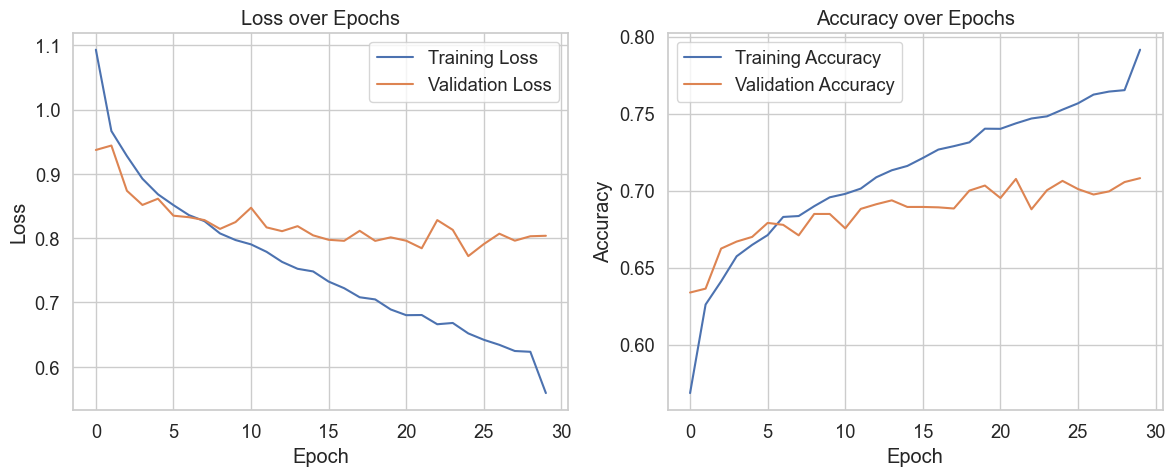

In [27]:
# Set up training parameters
input_size = X_train_pca.shape[1]  # Input dimension from BERT embeddings
hidden_size = 256
num_layers = 2
num_classes = 5
learning_rate = 0.001
batch_size = 64
num_epochs = 100  # Increase to 100 epochs
patience = 5  # Early stopping patience

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_pca)
y_train_tensor = torch.LongTensor(y_train_augmented.values)
X_test_tensor = torch.FloatTensor(X_test_pca)
y_test_tensor = torch.LongTensor(y_test.values)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create validation set for early stopping
val_size = int(0.1 * len(X_train_tensor))
train_size = len(X_train_tensor) - val_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size)

# Initialize model
model = BiLSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(MY_DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

# Training loop with early stopping
print("Training BiLSTM model...")
start_time = time.time()

# Lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Early stopping variables
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar for training
    loop = tqdm(train_loader, leave=True)
    for inputs, labels in loop:
        inputs, labels = inputs.to(MY_DEVICE), labels.to(MY_DEVICE)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Track metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item(), acc=correct/total)
    
    # Calculate training metrics
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = correct / total
    train_losses.append(train_epoch_loss)
    train_accs.append(train_epoch_acc)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(MY_DEVICE), labels.to(MY_DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    # Calculate validation metrics
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
    # Adjust learning rate based on validation loss
    scheduler.step(val_epoch_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')
    
    # Early stopping check
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_bilstm_model.pt')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

training_time = time.time() - start_time
print(f"Model trained in {training_time:.2f} seconds")

# Load best model
model.load_state_dict(torch.load('best_bilstm_model.pt'))

# Plot training and validation curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Model Evaluation - Basic Metrics

In [19]:
# Make predictions and calculate basic metrics
print("Evaluating model...")
model.eval()
with torch.no_grad():
    inputs = X_test_tensor.to(MY_DEVICE)
    outputs = model(inputs)
    _, y_pred = torch.max(outputs, 1)
    y_pred = y_pred.cpu().numpy()
    y_score = torch.softmax(outputs, dim=1).cpu().numpy()  # For ROC and PR curves

# Calculate basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating model...
Accuracy: 0.6921
Precision: 0.6917
Recall: 0.6921
F1 Score: 0.6902


In [20]:
# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=list(label_mapping.keys())))

Classification Report:
              precision    recall  f1-score   support

   not bully       0.76      0.76      0.76      2852
       troll       0.59      0.62      0.60      2031
      sexual       0.67      0.55      0.61      1726
   religious       0.77      0.84      0.80      1443
      threat       0.57      0.62      0.59       330

    accuracy                           0.69      8382
   macro avg       0.67      0.68      0.67      8382
weighted avg       0.69      0.69      0.69      8382



## 7. Confusion Matrix Visualization

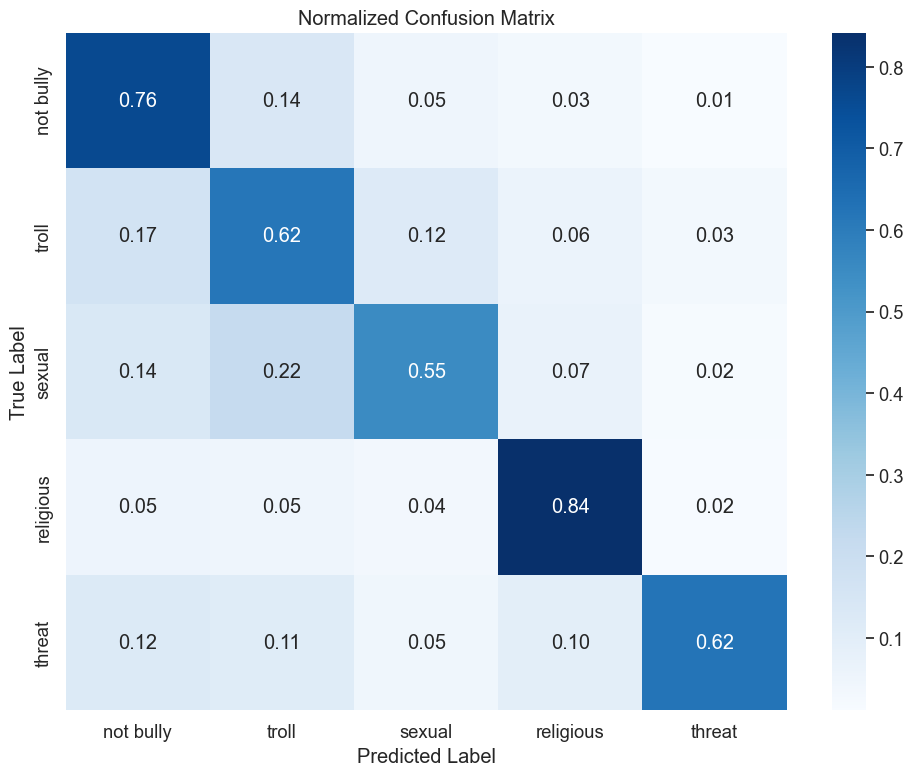

In [21]:
# Create and display confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

## 8. ROC Curve Analysis

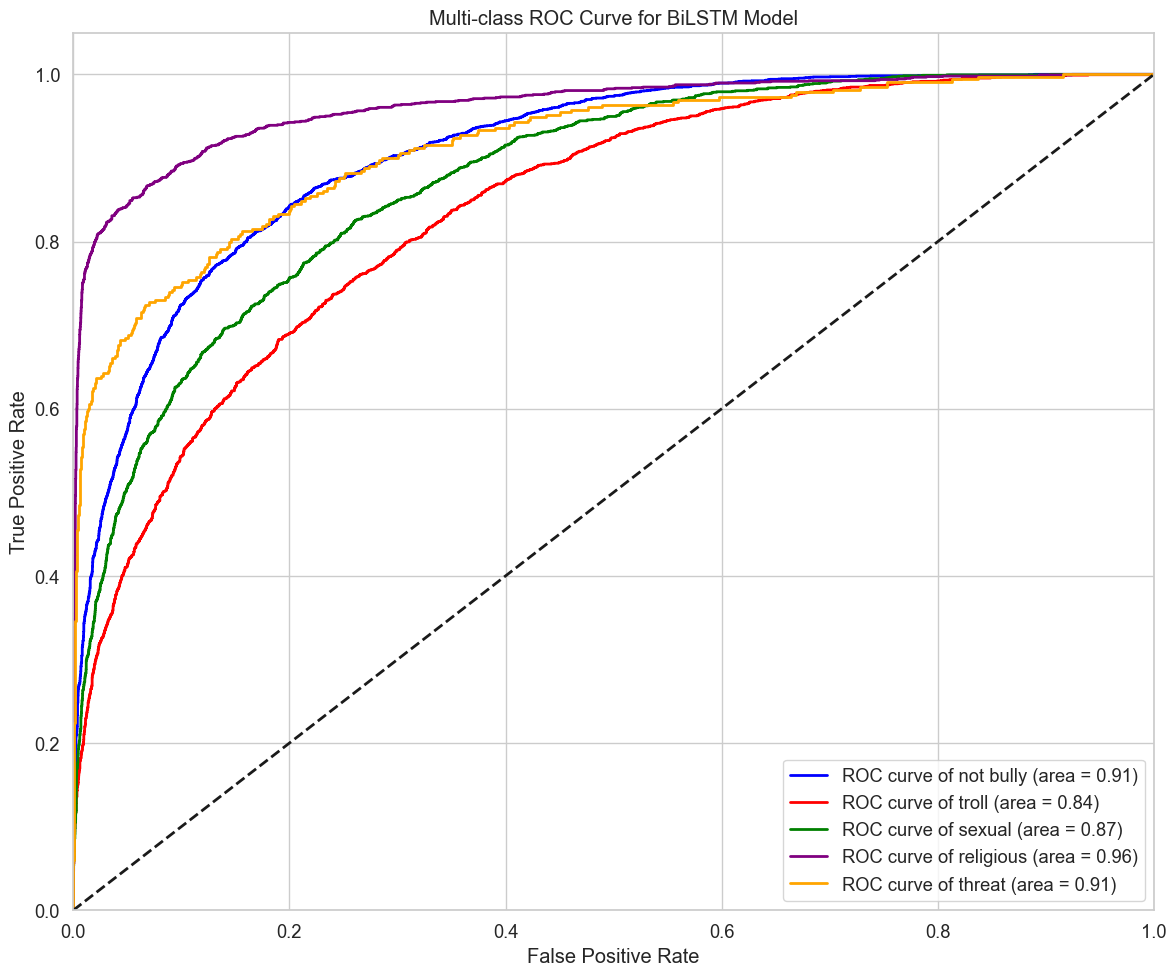

In [22]:
# ROC Curve and AUC for multi-class classification
# Use the softmax probabilities from BiLSTM model
y_test_bin = label_binarize(y_test, classes=range(5))

# Calculate ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 10))
colors = cycle(["blue", "red", "green", "purple", "orange"])
class_names = list(label_mapping.keys())

for i, color, class_name in zip(range(5), colors, class_names):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"ROC curve of {class_name} (area = {roc_auc[i]:.2f})",
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve for BiLSTM Model")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 10. Precision-Recall Curve Analysis

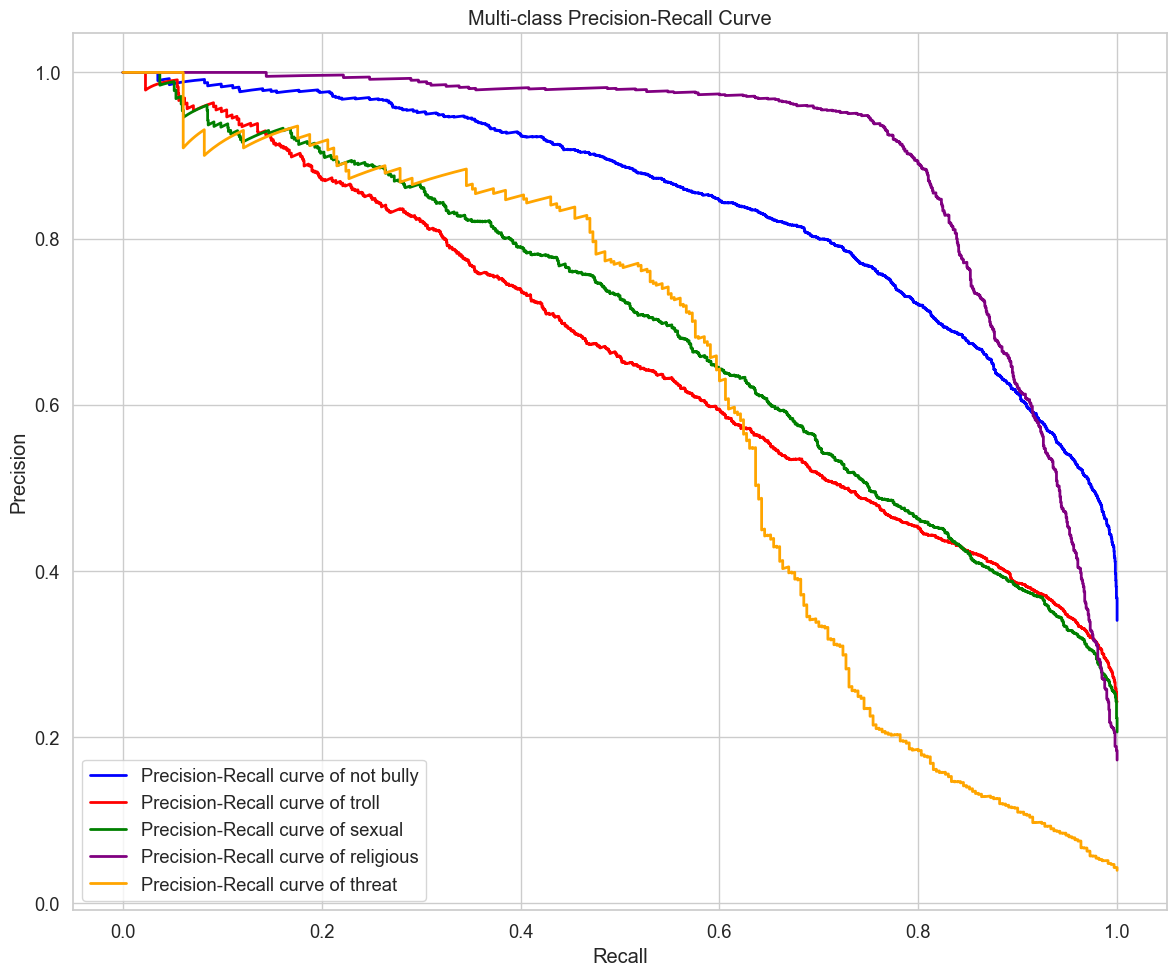

In [23]:
# Calculate Precision-Recall curve and average precision for each class
precision = {}
recall = {}
plt.figure(figsize=(12, 10))

for i, color, class_name in zip(range(5), colors, class_names):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(
        recall[i],
        precision[i],
        color=color,
        lw=2,
        label=f"Precision-Recall curve of {class_name}",
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## 12. Model Summary and Saving

In [24]:
# Summary of the model
print("Model Summary:")
print(f"Total samples in training set (with augmentation): {len(X_train_augmented)}")
print(f"Total samples in test set: {len(X_test)}")
print(f"Number of features (vector dimension): {X_train_vectors.shape[1]}")
print(f"Final model accuracy on test set: {accuracy:.4f}")

# Print model architecture
print("\nBiLSTM Model Architecture:")
print(model)

Model Summary:
Total samples in training set (with augmentation): 39606
Total samples in test set: 8382
Number of features (vector dimension): 3072
Final model accuracy on test set: 0.6921

BiLSTM Model Architecture:
BiLSTMClassifier(
  (lstm): LSTM(3072, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)


In [25]:
# Save the model
model_save_path = "../../models/bangla_bert/multiclass_bangla_bert_bilstm.pt"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'num_classes': num_classes,
    'accuracy': accuracy,
    'f1_score': f1
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ../../models/bangla_bert/multiclass_bangla_bert_bilstm.pt


In [26]:
# Example for loading and using the saved model
def load_bilstm_model(model_path):
    checkpoint = torch.load(model_path)
    model = BiLSTMClassifier(
        input_size=checkpoint['input_size'],
        hidden_size=checkpoint['hidden_size'],
        num_layers=checkpoint['num_layers'],
        num_classes=checkpoint['num_classes']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# Test loading
# loaded_model = load_bilstm_model(model_save_path)
# loaded_model.eval()